In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

import pymc3 as pm

%config InlineBackend.figure_format = "retina"
%matplotlib inline

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


I follow **Example 9** from [here](https://projecteuclid.org/ebooks/nsf-cbms-regional-conference-series-in-probability-and-statistics/Nonparametric-Bayesian-Inference/Chapter/Chapter-3-Dirichlet-Process/10.1214/cbms/1362163748) (displayed below) and attempt to also replicate the results shown in Figure 3.2. They assume that data are drawn i.i.d. from $\mathcal{N}(2, 4)$ but assume a base distribution $G_0 = \mathcal{N}(0, 1)$.

<img src="dp-example-9.png" width=500>

In [2]:
N = 20
K = 25
M = 5
rng = np.random.RandomState(seed=34)
G0 = lambda: rng.normal(loc=0., scale=1., size=[1,])

def Gn(alpha, G0, obs):
    """
    obs is a vector of observed data upon which we condition
    """
    
    n_obs = len(obs)
    idx = rng.binomial(n=1, p=alpha/(alpha + n_obs), size=[K+1,])
    
    posterior_draws = []
    
    for i in range(K+1):
        if idx[i] == 1:
            posterior_draws.append(float(G0()))
        elif idx[i] == 0:
            posterior_draws.append(rng.choice(obs))
        else:
            raise ValueError("Hmm something's not right")
            
    return np.array(posterior_draws)

In [3]:
x_plot = np.linspace(-4, 8, num=1001)

def cdf(alpha, obs):
    
    global w
    
    n_obs = len(obs)
    betas = np.random.beta(1, alpha + n_obs, size=[N, K])
    betas[:, 1:] = betas[:, 1:] * (1 - betas[:, :-1]).cumprod(axis=1)

    w = betas.copy() # weights
    w = np.hstack((w, (1 - w.sum(axis=1))[..., np.newaxis]))
    m = np.array([Gn(alpha, G0, obs) for _ in range(N)])

    dirac = np.less.outer(m, x_plot).astype(int)
    return (w[..., np.newaxis]*dirac).sum(axis=1)

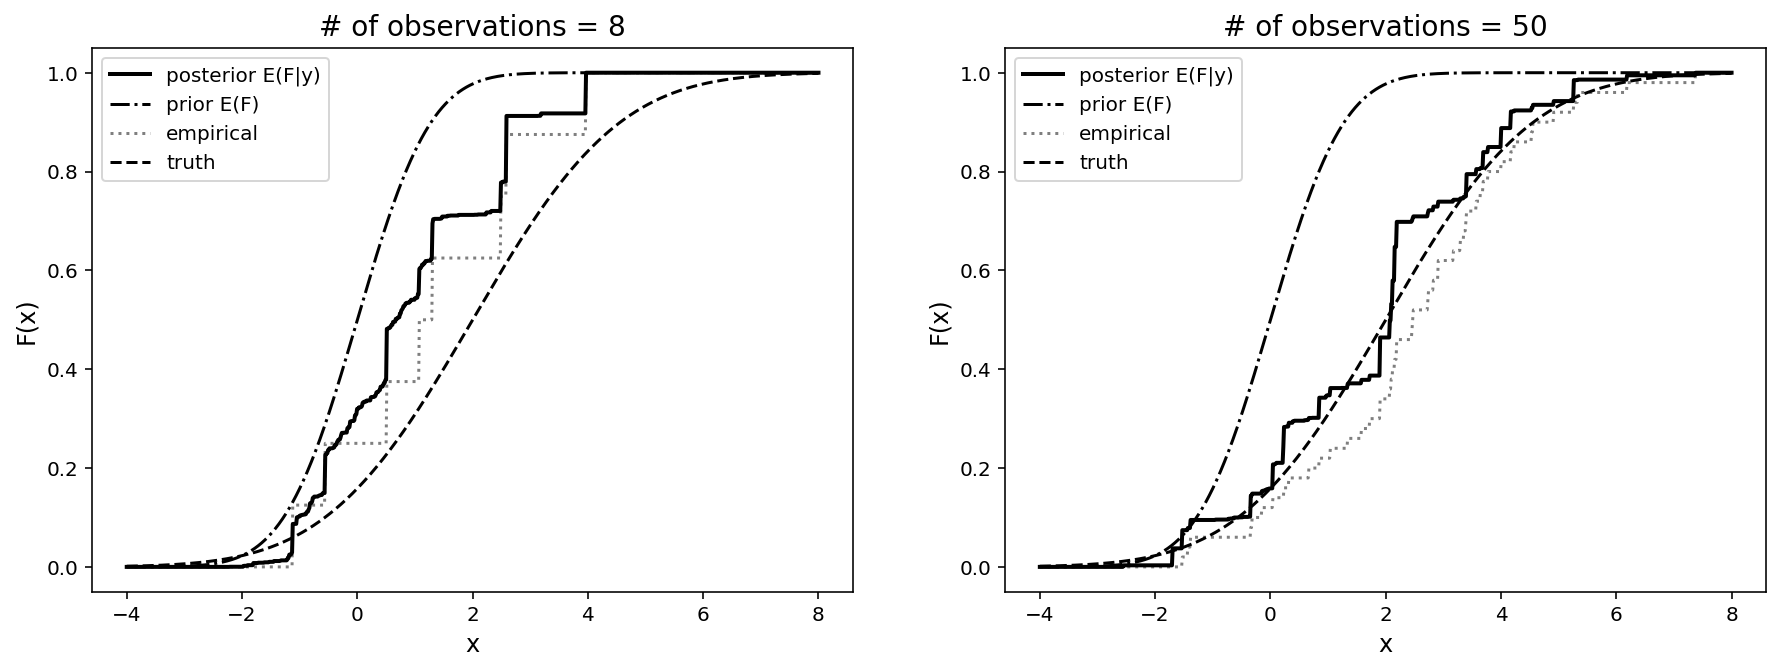

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# for i in range(N):
#     ax.plot(x_plot, dp_sample[i], c="k", alpha=0.1)

for fig_num in range(2):
    
    if fig_num == 0:
        n_obs = 8
    elif fig_num == 1:
        n_obs = 50
        
    x_obs = rng.normal(loc=2., scale=2., size=[n_obs,])
    dp_sample = cdf(5, x_obs)
    
    _ = ax[fig_num].plot(x_plot, dp_sample.mean(axis=0), c="k", linestyle="-", linewidth=2, label="posterior E(F|y)")
    _ = ax[fig_num].plot(x_plot, st.norm.cdf(x_plot), c="k", linestyle="-.", label="prior E(F)")
    _ = ax[fig_num].plot(x_plot, np.greater.outer(x_plot, x_obs).mean(axis=1), c="k", linestyle="dotted", alpha=0.5, label="empirical")
    _ = ax[fig_num].plot(x_plot, st.norm.cdf(x_plot, loc=2., scale=2.), c="k", linestyle="--", label="truth")
    
    _ = ax[fig_num].set_title(f"# of observations = {n_obs}", fontsize=14)
    _ = ax[fig_num].set_ylabel("F(x)", fontsize=12)
    _ = ax[fig_num].set_xlabel("x", fontsize=12)
    _ = ax[fig_num].legend()